In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import Morlet, Cauchy, DoG, MexicanHat
import time
from scipy import signal

"This notebook requires MAGPRIME for data loading. Uncomment to install."
# !pip install git+https://github.com/aphoffmann/MAGPRIME.git
from magprime import utility

c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\pymssa\mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Load Example Data from Michibiki-1 Spacecraft Magnetoemter

In [2]:
B = utility.load_michibiki_data()[:,2]
sample_rate = .1
B = B[:, ::10] # Decimate to 0.1 Hz

#### Create Transform Object and Analysis Filters

In [3]:
fb = LinearFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=2*8640, real=True, b = 400, compensation=False)
transform = Transform(
    Wfreq=fb.Wfreq
)

C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_8888\4122899369.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(fb.Wfreq)),aspect='auto', origin='lower')


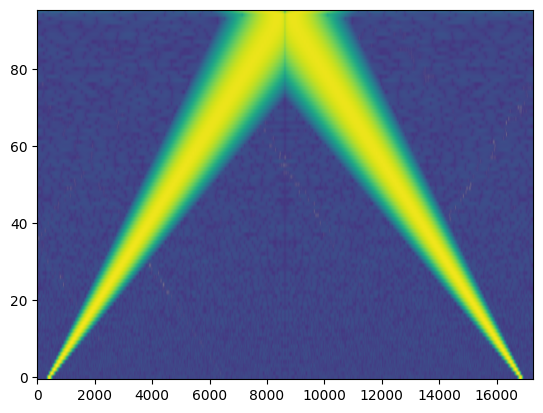

In [4]:
plt.imshow(np.log(np.abs(fb.Wfreq)),aspect='auto', origin='lower')

c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\envs\mag\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Time taken for WAICUP:  1.8286874294281006


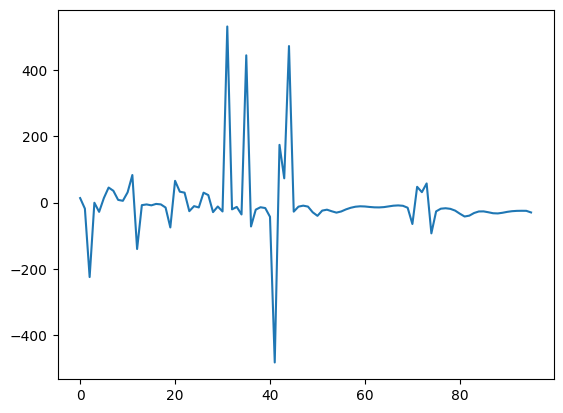

In [5]:
#### WAICUP
start = time.time()

w1 = transform.forward(B[0], mode='full')
w2 = transform.forward(B[1], mode='full')

D = w2 - w1  # shape (J, T), complex


# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D * w1, axis=1 )   # shape (J,)
C2 = np.sum( D * w2, axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = C2/C1                 # shape (J,)

# (optionally force to real if you know K is real:)

plt.plot(K_hat, label='K_hat')

# 3) residuals (eq 9)
A1 = (w1-w2) / (K_hat[:,None]-1 )  # shape (J, T), complex

# 4) ambient‑field estimate X(s,τ) (eq 10)
X1 = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

result = transform.inverse(X1, mode='full', Lx=8640)
interference = transform.inverse(A1, mode='full', Lx=8640)
end = time.time()
print("Time taken for WAICUP: ", end - start)

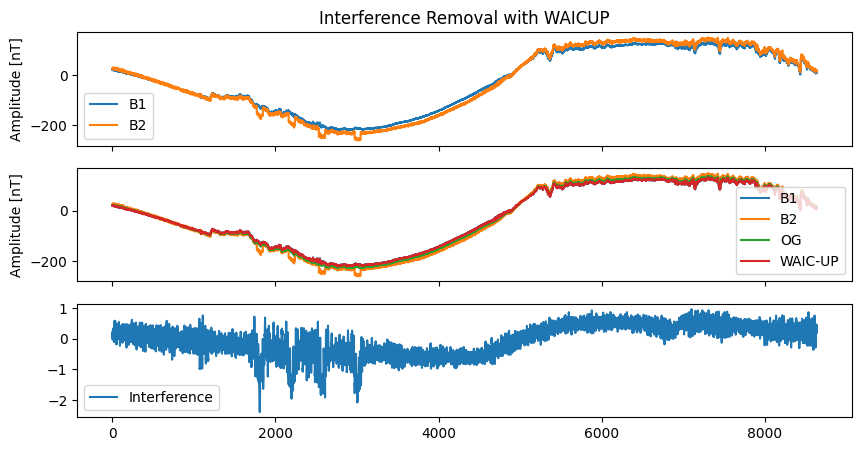

In [6]:
from magprime.algorithms import WAICUP
%matplotlib inline
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10, 5))


ax[0].plot(B[0], label='B1')
ax[0].plot(B[1], label='B2')
ax[0].legend()
ax[1].plot(B[0], label='B1')
ax[1].plot(B[1], label='B2')

ax[1].plot(WAICUP.clean(B, triaxial=False), label='OG')
ax[1].plot(result, label='WAIC-UP')
ax[2].plot(interference, label='Interference')
ax[1].legend()
ax[2].legend()
ax[0].set_title('Interference Removal with WAICUP')
ax[0].set_ylabel('Amplitude [nT]')

ax[1].set_ylabel('Amplitude [nT]')
ax[0].legend()
ax[1].legend()
plt.show()